In [3]:
from google.colab import drive
drive.mount('/content/drive')
#import os
%cd '/content/drive/MyDrive/FNO_cluster'

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchsummary import summary

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

from Adam import Adam
torch.manual_seed(0)
np.random.seed(0)

Mounted at /content/drive
/content/drive/MyDrive/FNO_cluster


In [ ]:
print(torch.__version__)

1.12.0+cu113


In [ ]:
class super_res_normalizer:
    def __init__(self, mean, std, eps=0.00001):
        mean = torch.concat((mean,mean,mean,mean),dim=0)
        self.mean = torch.concat((mean,mean,mean,mean),dim=1).cuda()
        std = torch.concat((std,std,std,std),dim=0)
        self.std = torch.concat((std,std,std,std),dim=1).cuda()
        self.eps = torch.tensor(eps).cuda()

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        self.std = self.std.cuda()
        self.eps = self.eps.cuda()
        std = self.std + self.eps # n
        mean = self.mean
        x = (x * std) + mean
        return x.cuda()

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))  #kernel needs to be learned
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights) #how to understand this

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device) #last 2 dimensions: coordinates in the frequency domain
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)   #real values only first modes1 and modes2 are extracted
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)  #complex values

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))  #inverse transform; dimension same with the padded image
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y) #encoder

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x) #fourier operation
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x1 = self.conv4(x)  #I added one more block to increase the flexbility of the iterative scheme
        x2 = self.w4(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



In [ ]:
################################################################
# configs
################################################################
TRAIN_x_PATH = '/content/drive/MyDrive/FNO_cluster/SE_ovl_train.mat' #please change this path in quest
TRAIN_y_PATH = '/content/drive/MyDrive/FNO_cluster/P_train.mat' #please change this path in quest

TEST_x_PATH = '/content/drive/MyDrive/FNO_cluster/SE_ovl_test.mat' #please change this path in quest
TEST_y_PATH = '/content/drive/MyDrive/FNO_cluster/P_test.mat' #please change this path in quest


#super_res = '/content/drive/MyDrive/FNO_data/super_resolution/super_res.mat'

batch_size = 50
learning_rate = 0.0005

ntrain = 1497
ntest = 500
s = 181   #pixel size

epochs = 200
step_size = 100
gamma = 0.5

modes = 64 #fourier modes
width = 50 #decoded dimension

In [ ]:
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_x_PATH)
x_train = reader.read_field('SE_ovl_train')[3:,::,::]

reader = MatReader(TEST_x_PATH)
x_test = reader.read_field('SE_ovl_test')[:,::,::]

reader = MatReader(TRAIN_y_PATH)
y_train = reader.read_field('P_train')[3:,::,::]

reader = MatReader(TEST_y_PATH)
y_test = reader.read_field('P_test')[:,::,::]

print(y_train.size())
#reader = MatReader(super_res)
#super_x = reader.read_field('input_geo')[:,::,::]
#super_y= reader.read_field('sigma_xx')[:,::,::]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test) #test data is normalized based on train data

torch.Size([1497, 181, 181])


In [ ]:
#super_x_normalizer = super_res_normalizer(x_normalizer.mean, x_normalizer.std)
#super_x = super_x.cuda()
#super_x = super_x_normalizer.encode(super_x)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

#super_y_normalizer = super_res_normalizer(y_normalizer.mean, y_normalizer.std)

x_train = x_train.reshape(ntrain,s,s,1)
x_test = x_test.reshape(ntest,s,s,1)
#super_x = super_x.reshape(3,1024,1024,1)

In [ ]:
x_normalizer.mean.size()

torch.Size([181, 181])

In [ ]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, drop_last=True)
#super_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(super_x, super_y), batch_size=1, shuffle=False, drop_last=True)

In [ ]:
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

204819607


In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

fc0.weight 	 torch.Size([50, 3])
fc0.bias 	 torch.Size([50])
conv0.weights1 	 torch.Size([50, 50, 64, 64])
conv0.weights2 	 torch.Size([50, 50, 64, 64])
conv1.weights1 	 torch.Size([50, 50, 64, 64])
conv1.weights2 	 torch.Size([50, 50, 64, 64])
conv2.weights1 	 torch.Size([50, 50, 64, 64])
conv2.weights2 	 torch.Size([50, 50, 64, 64])
conv3.weights1 	 torch.Size([50, 50, 64, 64])
conv3.weights2 	 torch.Size([50, 50, 64, 64])
conv4.weights1 	 torch.Size([50, 50, 64, 64])
conv4.weights2 	 torch.Size([50, 50, 64, 64])
w0.weight 	 torch.Size([50, 50, 1, 1])
w0.bias 	 torch.Size([50])
w1.weight 	 torch.Size([50, 50, 1, 1])
w1.bias 	 torch.Size([50])
w2.weight 	 torch.Size([50, 50, 1, 1])
w2.bias 	 torch.Size([50])
w3.weight 	 torch.Size([50, 50, 1, 1])
w3.bias 	 torch.Size([50])
w4.weight 	 torch.Size([50, 50, 1, 1])
w4.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([128, 50])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([1, 128])
fc2.bias 	 torch.Size([1])


In [ ]:
summary(model, (500, 500, 1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [-1, 500, 500, 50]             200
    SpectralConv2d-2         [-1, 50, 509, 509]               0
            Conv2d-3         [-1, 50, 509, 509]           2,550
    SpectralConv2d-4         [-1, 50, 509, 509]               0
            Conv2d-5         [-1, 50, 509, 509]           2,550
    SpectralConv2d-6         [-1, 50, 509, 509]               0
            Conv2d-7         [-1, 50, 509, 509]           2,550
    SpectralConv2d-8         [-1, 50, 509, 509]               0
            Conv2d-9         [-1, 50, 509, 509]           2,550
   SpectralConv2d-10         [-1, 50, 509, 509]               0
           Conv2d-11         [-1, 50, 509, 509]           2,550
           Linear-12        [-1, 500, 500, 128]           6,528
           Linear-13          [-1, 500, 500, 1]             129
Total params: 19,607
Trainable params: 

In [ ]:
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()
    #loss for super resolution data 1024*1024
    #super_l2 = 0.0
    #with torch.no_grad():
    #    for x, y in super_loader:
    #        x, y = x.cuda(), y.cuda()

    #        out = model(x).reshape(1, 1024, 1024) #batch size for super dataset is 1 in the current version
    #        out = super_y_normalizer.decode(out.cpu())

     #       super_l2 += myloss(out.view(1,-1), y.view(1,-1)).item() #batch size for super dataset is 1 in the current version

    train_l2/= ntrain
    test_l2 /= ntest
    #super_l2/= 3

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)


In [ ]:
out = super_y_normalizer.decode(out.cpu())
out.type()

NameError: name 'super_y_normalizer' is not defined

In [2]:
id = 10
s = 181
with torch.no_grad():

    geometry = x_test[id,:,:].reshape(1,s,s,1)
    pred = model(geometry.cuda()).reshape(1, s, s)
    
    pred = y_normalizer.decode(pred)
    pred = pred.reshape(s,s).cpu().numpy()

    target = y_test[id,:,:]
    target = target.reshape(s,s).numpy()
    


plt.figure(2)
ax2 = plt.subplot()
im2 = plt.imshow(target)
plt.colorbar(im2)
plt.clim(np.min(pred),np.max(pred))

plt.figure(3)
ax3 = plt.subplot()
im3 = plt.imshow(pred)
plt.colorbar(im3)
plt.clim(np.min(pred),np.max(pred))

plt.figure(4)
ax4 = plt.subplot()
im4 = plt.imshow(target - pred)
plt.colorbar(im4)

NameError: ignored

In [ ]:
y_normalizer.mean.size()


array([[-198.22266 , -202.34412 , -207.64612 , ..., -173.26965 ,
        -171.85632 , -169.93726 ],
       [-167.92151 , -175.75977 , -178.40613 , ..., -145.9043  ,
        -142.80737 , -141.26782 ],
       [-135.00134 , -143.43164 , -148.2544  , ..., -114.02197 ,
        -114.1969  , -115.55701 ],
       ...,
       [ -90.85162 ,  -88.68695 ,  -85.247314, ..., -101.1098  ,
         -95.960815,  -88.586914],
       [-108.118164, -107.48883 , -113.86981 , ..., -125.512085,
        -121.92413 , -116.007324],
       [-134.276   , -134.36566 , -131.32654 , ..., -144.1081  ,
        -142.94464 , -139.30304 ]], dtype=float32)

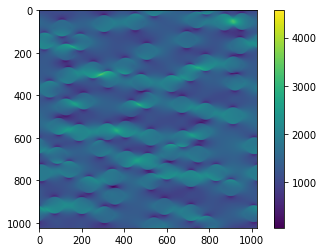

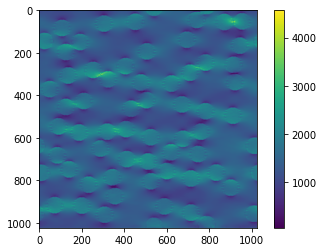

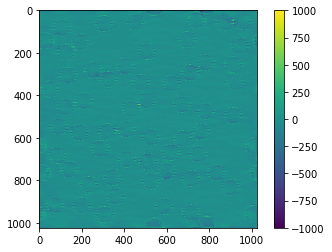

In [ ]:
s = 1024
id = 1
with torch.no_grad():

    geometry = super_x[id,:,:].reshape(1,s,s,1)
    pred = model(geometry.cuda()).reshape(1, s, s)

    super = super_res_normalizer(y_normalizer.mean, y_normalizer.std, pred)
    pred = super.decode(pred)
    pred = pred.reshape(s,s).cpu().numpy()

    target = super_y[id,:,:]
    target = target.reshape(s,s).numpy()
    


plt.figure(2)
ax2 = plt.subplot()
im2 = plt.imshow(target)
plt.colorbar(im2)
plt.clim(np.min(pred),np.max(pred))

plt.figure(3)
ax3 = plt.subplot()
im3 = plt.imshow(pred)
plt.colorbar(im3)
plt.clim(np.min(pred),np.max(pred))

plt.figure(4)
ax4 = plt.subplot()
im4 = plt.imshow(target - pred)
plt.colorbar(im4)
plt.clim(-1000,1000)
(target-pred)

In [ ]:
np.mean(target - pred)

-22.121996

In [ ]:
torch.save(model, '/content/drive/MyDrive/FNO_data/FNO_RVE_175_epoch.pt')

In [ ]:
model1 = torch.load('/content/drive/MyDrive/FNO_data/FNO_RVE_175_epoch.pt')
print(count_params(model1))

204819607


In [ ]:
super_res = '/content/drive/MyDrive/FNO_data/super_resolution/super_res_r20.mat'
TRAIN_x_PATH = '/content/drive/MyDrive/FNO_data/train_r10_geo.mat'
reader = MatReader(TRAIN_x_PATH)
x_train = reader.read_field('train_r10_input_geo')[:,::,::]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)

reader = MatReader(super_res)
super_x = reader.read_field('input_geo')[:,::,::].cuda()
super_y= reader.read_field('sigma_xx')[:,::,::]
super_x_normalizer = super_res_normalizer(x_normalizer.mean, x_normalizer.std)
super_x = super_x_normalizer.encode(super_x)
super_x = super_x.reshape(3,1024,1024,1)
super_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(super_x, super_y), batch_size=1, shuffle=False, drop_last=True)

In [ ]:
super_x.type()

'torch.FloatTensor'

Test for 1024 r20 rve

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


array([[-372.85364 , -331.46686 , -303.48816 , ..., -319.11047 ,
        -270.38208 , -246.25098 ],
       [-288.49103 , -290.75854 , -290.52478 , ..., -333.3283  ,
        -312.6162  , -262.36536 ],
       [-322.13324 , -241.34973 , -188.73547 , ..., -343.021   ,
        -257.06097 , -218.48187 ],
       ...,
       [-108.198425, -110.47284 , -110.75891 , ..., -185.61566 ,
        -187.2821  , -174.67291 ],
       [-171.15149 , -132.89594 , -107.23828 , ..., -221.77588 ,
        -193.32025 , -181.96484 ],
       [-168.3371  , -170.52399 , -164.73224 , ..., -255.75977 ,
        -247.99231 , -223.72925 ]], dtype=float32)

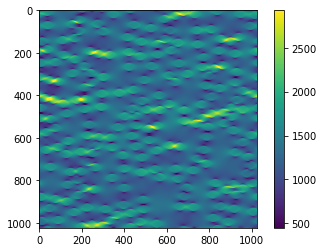

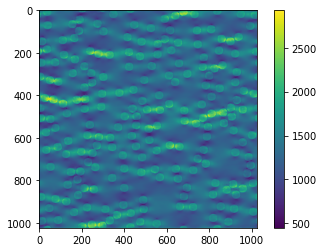

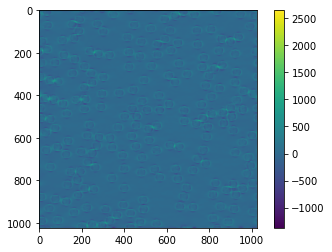

In [ ]:
myloss = LpLoss(size_average=False)
s = 1024
id = 0
with torch.no_grad():

    geometry = super_x[id,:,:].reshape(1,s,s,1)
    pred = model1(geometry.cuda()).reshape(1, s, s)

    super = super_res_normalizer(y_normalizer.mean, y_normalizer.std, pred)
    pred = super.decode(pred)
    target = super_y[id,:,:].reshape(s,s).cuda()
    
    super_l2_r20 = myloss(pred.view(1,-1), target).item()
    pred = pred.reshape(s,s).cpu().numpy()
    target = target.cpu().numpy()
    
    
    
    


plt.figure(2)
ax2 = plt.subplot()
im2 = plt.imshow(target)
plt.colorbar(im2)
plt.clim(np.min(pred),np.max(pred))

plt.figure(3)
ax3 = plt.subplot()
im3 = plt.imshow(pred)
plt.colorbar(im3)
plt.clim(np.min(pred),np.max(pred))

plt.figure(4)
ax4 = plt.subplot()
im4 = plt.imshow(target - pred)
plt.colorbar(im4)
#plt.clim(-1000,1000)
(target-pred)

In [ ]:
print(super_l2_r20)

0.08696935325860977
